In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix

In [3]:
df = pd.read_csv('/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv')
#df = pd.read_csv('/Users/lecueguillaume/Documents/bnpp/bnpp_donnees/ETSAnonymousPricesFull_2.csv')

/Users/arnaud/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
ls -al /Users/lecueguillaume/Documents/bnpp/bnpp_donnees/

ls: /Users/lecueguillaume/Documents/bnpp/bnpp_donnees/: No such file or directory


In [5]:
nb_customers = len(set(df['Customer']))
nb_tickers = len(set(df['Ticker']))
row_idx = {tck: i for i, tck in enumerate(set(df['Ticker']))}

In [6]:
df['TradeDate'] = pd.to_datetime(df['TradeDate'], format='%Y%m%d')  # Transform date into real dates

In [7]:
df.head()

,Customer,Sales,Trader,Trader1,SalesTeam,CustomerTrader,VoiceElec,BuySell,Currency,RFQId,...,CDSSeniority,SalesLocation,TraderLocation,JagPositionCCY,StarPositionCCY,Benchmark,ANPrice,PV01,StpPortfolio,Bid2MidComp
0,468,12,18,2,12,4135,ELEC,Sell,USD,00000001_20140203_08,...,SEN,SIN,LON,1000000000,1000000000,NaN,NaN,NaN,NaN,0.274998
1,36,27,1,1,3,178,ELEC,Buy,EUR,00000001_20141002_08,...,SUB,FRA,LON,0,-90000,NaN,110.499,5.339746,12725,0.385000
2,203,27,21,1,3,3261,ELEC,Buy,EUR,00000002_20140203_08,...,SEN,FRA,LUX,1000000000,1000000000,NaN,NaN,NaN,NaN,0.022251
3,3,1,8,1,2,18,ELEC,Sell,EUR,00000002_20140501_08,...,SEN,ZRH,LON,1000000000,1000000000,NaN,NaN,NaN,NaN,0.338093
4,2,12,1,1,12,1697,ELEC,Buy,USD,00000002_20141002_08,...,PRE,SIN,LON,0,310000,NaN,103.403,3.635802,30140,0.405000


### Format data

In [64]:
data = df.ix[df["BuySell"] == "Buy", [u'Customer', u'NotionalEUR', u'Ticker', u'TradeDate']]

In [65]:
data.head()

,Customer,NotionalEUR,Ticker,TradeDate
1,36,50000.000000,NDB,2014-10-02
2,203,1500000.000000,REPSM,2014-02-03
4,2,789016.884961,BACR,2014-10-02
6,2,789016.884961,ACAFP,2014-10-02
8,203,1000000.000000,EVKGR,2014-02-03


We first separate the RFQs in train and test sets. All RFQs done before a certain date are added to the train set and the remaining ones go to the test set.

In [66]:
cut_date = pd.to_datetime('20140606', format='%Y%m%d')  # 2014-06-06 so that 75% of the data is used for train

data_train = data[data[u'TradeDate'] <= cut_date]
data_test = data[data[u'TradeDate'] > cut_date]

print "#train = %s" % data_train.shape[0]
print "#test = %s" % data_test.shape[0]

#train = 388385
#test = 156655


Most of the preprocessing is done here:

- Keep only customers with more than 10 trades (10 in training, 10 for testing independently) 
- Aggregate the `NotionalEUR` variable using the `sum` operator and discretize it using quartiles.
- replace the string of the `Ticker` by its id.

** !!! I have changed the pre-processing !!! See `Another kind of pre-processing` **

In [67]:
cut_count = 10
n_bins = 4
labels = range(1, n_bins + 1)

train_dense = data_train.groupby(['Customer', 'Ticker'])
train_dense = train_dense['NotionalEUR'].agg({'NotionalSum' : np.sum, 'count' : 'count'}).reset_index()
train_dense = train_dense.groupby('Customer').filter(lambda x: sum(x['count']) >= cut_count)
train_dense[u'NotionalRating'], bins = pd.qcut(train_dense[u'NotionalSum'], n_bins, labels=labels, retbins=True)
# train_dense[u'NotionalRating'] = train_dense[u'NotionalSum']  # See `Another kind of pre-processing`

test_dense = data_test.groupby(['Customer', 'Ticker'])
test_dense = test_dense['NotionalEUR'].agg({'NotionalSum' : np.sum, 'count' : 'count'}).reset_index()
test_dense = test_dense.groupby('Customer').filter(lambda x: sum(x['count']) >= cut_count)
test_dense[u'NotionalRating'] = pd.cut(test_dense[u'NotionalSum'], bins, labels=labels)
# test_dense[u'NotionalRating'] = test_dense[u'NotionalSum']

train_dense['Ticker'] = train_dense['Ticker'].map(lambda x: row_idx[x])
test_dense['Ticker'] = test_dense['Ticker'].map(lambda x: row_idx[x])

train_dense.drop(['count', 'NotionalSum'], axis=1, inplace=True)
test_dense.drop(['count', 'NotionalSum'], axis=1, inplace=True)

In [68]:
train_dense.head()

,Customer,Ticker,NotionalRating
0,1,859,3
1,1,662,4
2,1,658,1
3,1,521,4
4,1,1220,2


The matrices are potentially quite big and the CSR sparse representation will be more memory efficient. 

** !!! Note It seems that dense matrices are trained on faster using NIMFA. !!!**

In [69]:
from scipy.sparse import coo_matrix

In [70]:
data = train_dense['NotionalRating']
row = train_dense['Customer']
col = train_dense['Ticker']
train_coo = coo_matrix((data, (row, col)), shape=(nb_customers, nb_tickers))
train_coo

<2030x1258 sparse matrix of type '<type 'numpy.int64'>'
	with 81972 stored elements in COOrdinate format>

In [71]:
data = test_dense['NotionalRating']
row = test_dense['Customer']
col = test_dense['Ticker']
test_coo = coo_matrix((data, (row, col)), shape=(nb_customers, nb_tickers))
test_coo

<2030x1258 sparse matrix of type '<type 'numpy.float64'>'
	with 47407 stored elements in COOrdinate format>

In [72]:
td_train = np.array(train_coo.todense())
td_test = np.array(test_coo.todense())

At this point the data should be in the right format for non-negative matric factorization.

### Another kind of preprocessing

Bucketizing according to `NotionalSum` may not be a very good description for the 'user-item' matrix. Here I normalize each line (client) so that it represents its tendency to buy large amounts of a given column (ticker)

<matplotlib.colorbar.Colorbar instance at 0x10d629290>

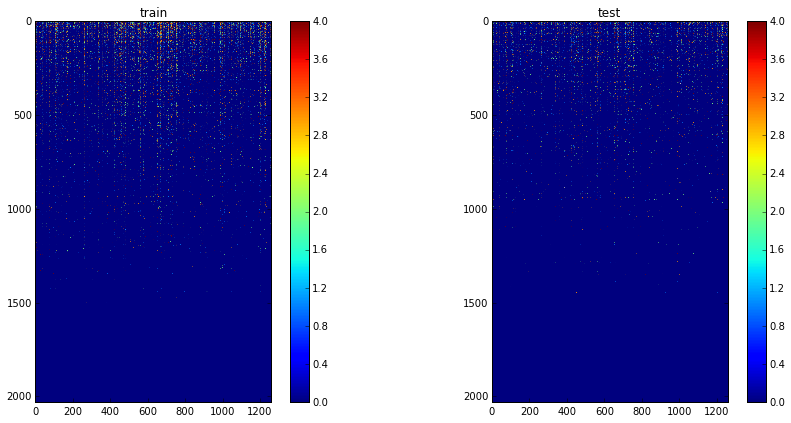

In [73]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
# norm = np.sum(train_coo.todense(), axis=1)
# idx = np.array(norm > 0).T[0]
# td_train = train_coo.todense()[idx, :] / np.tile(norm[idx, :], (1, nb_tickers))
plt.title("train")
plt.imshow(td_train[1:, :])
plt.colorbar()

plt.subplot(2,2,2)
# td_test = test_coo.todense()[idx, :] / np.tile(np.sum(test_coo.todense(), axis=1)[idx, :], (1, nb_tickers))
# td_test[np.isnan(td_test)] = 0.
plt.title("test")
plt.imshow(td_test[1:, :])
plt.colorbar()

We can compare clients directly. Below is a comparison of three clients chosen randomly.

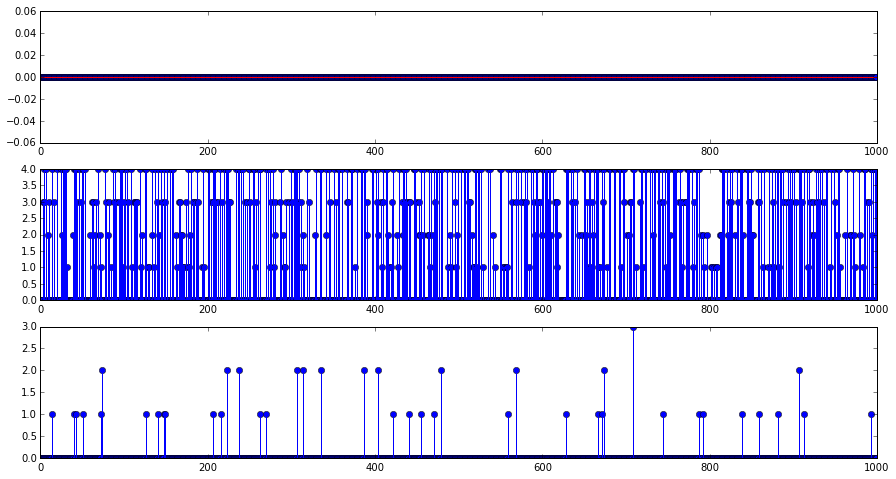

In [75]:
plt.figure(figsize=(15, 8))
plt.subplot(3,1,1)
plt.stem(np.array(td_train[0, :1000]))
plt.subplot(3,1,2)
plt.stem(np.array(td_train[1, :1000]))
plt.subplot(3,1,3)
plt.stem(np.array(td_train[100, :1000]))
plt.show()

### Training using NMF

In [76]:
import nimfa
from timeit import default_timer as timer

In [77]:
# Using dense matrices currently as they fit in memory 
# and are faster to train for an unknown reason.

start = timer()
model = nimfa.Nmf(td_train, seed='random_vcol', rank=10, max_iter=100)
mfit = model()
dt = timer() - start
print "Lsnmf created in %f s" % dt

Lsnmf created in 2.969378 s


In [78]:
print('Rss: %5.4f' % mfit.fit.rss())
print('Evar: %5.4f' % mfit.fit.evar())
print('K-L divergence: %5.4f' % mfit.distance(metric='kl'))
print('Sparseness, W: %5.4f, H: %5.4f' % mfit.fit.sparseness())

Rss: 315959.5315
Evar: 0.4783
K-L divergence: 257665.6293
Sparseness, W: 0.6716, H: 0.6905


In [79]:
M = np.array(mfit.coef())
N = np.array(mfit.basis())

print nb_customers, nb_tickers
print M.shape
print N.shape

2030 1258
(10, 1258)
(2030, 10)


In [80]:
NM = N.dot(M)

In [81]:
p = np.argmax(NM, axis=1)
NM[0, :].shape

(1258,)

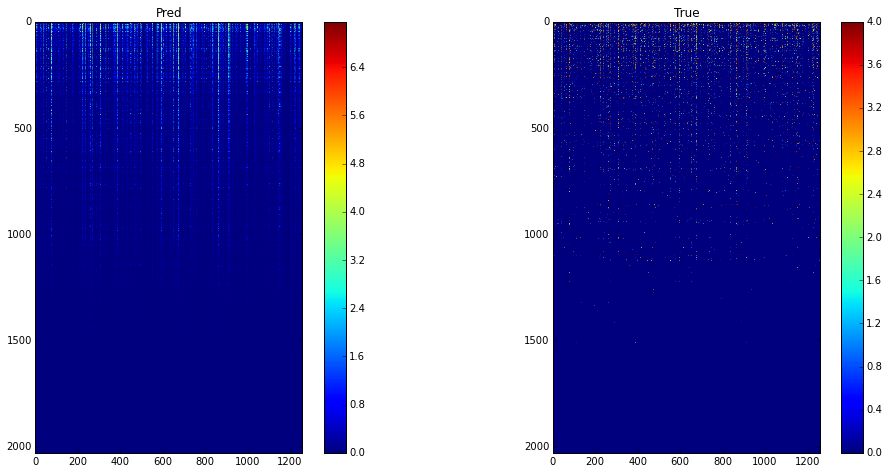

In [82]:
plt.figure(figsize=(17, 17))
plt.subplot(2, 2, 1)
plt.imshow(NM)
plt.colorbar()
plt.title("Pred")
plt.subplot(2, 2, 2)
plt.imshow(td_test) # This is the wrong way to do it
plt.colorbar()
plt.title("True")
plt.show()

### Clustering with KMeans

In [83]:
from sklearn.cluster import KMeans

In [84]:
km = KMeans(n_clusters=10)

In [85]:
print M.T.shape

km.fit(M.T)

(1258, 10)


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [86]:
Y = km.predict(M.T)

In [87]:
print [sum(Y == i) for i in range(10)]

[25, 696, 38, 194, 143, 71, 21, 24, 19, 27]


In [88]:
inverse = {i:tck for tck, i in row_idx.iteritems()}

In [89]:
for i, y in enumerate(Y):
    if y == 1:
        print inverse[i],

nan JAFZSK NOKIA MAPSM BMO SIB COOPWH SBAB SENEGL CXGD MUNHYP PELHOL NXPI LSTON DUBAIH EXANE PBBGR ADSGR INAER VERAV NEDWBK GLFP RCOFP RCOLIN AMLIN EMGLN GT CTRL BKNYML PGIM ADPFP AZRAIL HYNOE NOVAFR PERI MABLN FMEGR GM GLJGR BMY ISSDC HOUSF COFBBB FXPOLN REPNAM BREMLB STTESE JNJ IVYCST SNTCSS VORHYP NIBCAP EVN DISCA TNEFT YBS MACIFS LBBW EUROB CRBKMO ANGOL DTV FOURSN REXLN CEMEX EWOSAS BNAGRI FCCSM WMTRES AKTIA SNSPW ADRIT JOHLEW NACN K MARSLN GATESW SILVMA CANARY PSMGR BASQUE OSPRAQ HCN OVAKOA RPCUH OFFMAC TCOKZ DLR BNSELL ONOSM BALEAR REPCON TTLINF NDAQ CMCSA FHYDRO KPERST DLGLN MANCHA DMGTLN LABFP RMGLN JUTURN PORTAV COMHSS PMIPLC DISINT AVINOR TCHEN AVAN HASTNS BSY MSSIN ALFASS MAGYAR MMBFP RWANDA ALNTF ASRNED QIBKQD GGB ALDESA SIBUR PHONLN AMSSM USIMIT GULINT TRANLN PEALLN SZUGR JEF SOAFSK FREGR HEMABV SMINLN PREMI MMM POSAV GOTVER CAJARU MEDIFP SAMBNK VOYA PCLN CAIXAC CAPFP CAT ENEXIS HAVFP ERF ATFBP GIS EIBUH IREIM ROTH AZERBJ VOYCAR IKKSFR UBMLN RUSB SHGFIN EUROGT UKRINF CAIXA

### Visualisation: t-SNE and Hierarchical clustering

In [32]:
from sklearn.manifold import TSNE

In [33]:
tsne = TSNE(n_components=2, random_state=0)
T = tsne.fit_transform(M.T)

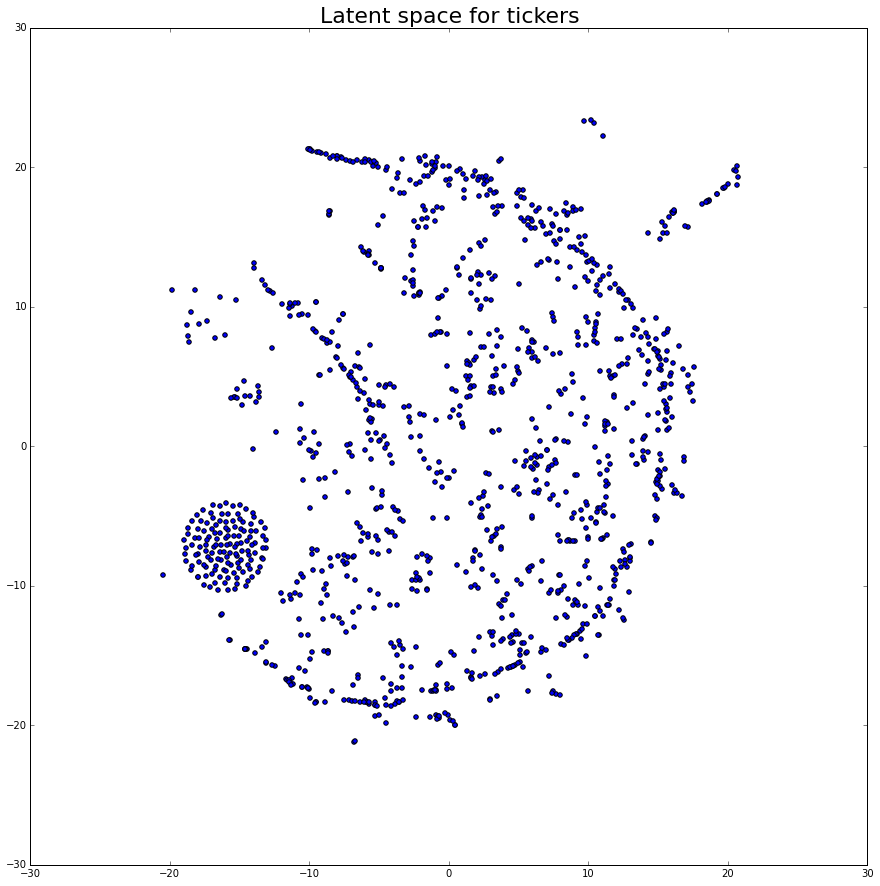

In [34]:
from mpld3 import enable_notebook # this is a very nice widget for matplotlib
from mpld3 import plugins
enable_notebook()

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Latent space for tickers", size=22)
points = ax.scatter(T[:, 0], T[:, 1])

#for i in range(len(Y)):
#    plt.annotate(inverse[i], (T[i, 0], T[i, 1]))
    
labels = []
for i in range(len(Y)):
#    plt.annotate(inverse[i], (T[i, 0], T[i, 1]))
    labels.append("{}, {}, {}".format(inverse[i], T[i, 0], T[i, 1]))
                        
tooltip = plugins.PointLabelTooltip(points, labels)

plugins.connect(fig, tooltip)

In [65]:
import scipy.cluster.hierarchy as sch

In [66]:
L = sch.linkage(M.T.dot(M), method='centroid')

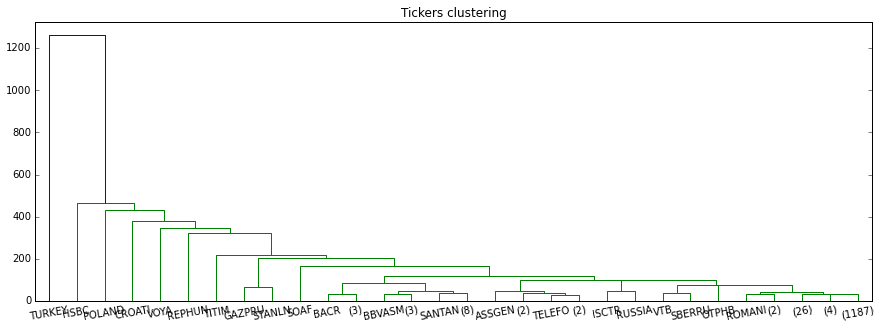

In [67]:
plt.figure(figsize=(15, 5))
Z = sch.dendrogram(L,
                   labels=[inverse[i] for i in range(nb_tickers)],
                   leaf_rotation=100,
                   truncate_mode='lastp')
plt.title("Tickers clustering")
plt.show()

In [68]:
L = sch.linkage(N.dot(N.T), method='centroid')

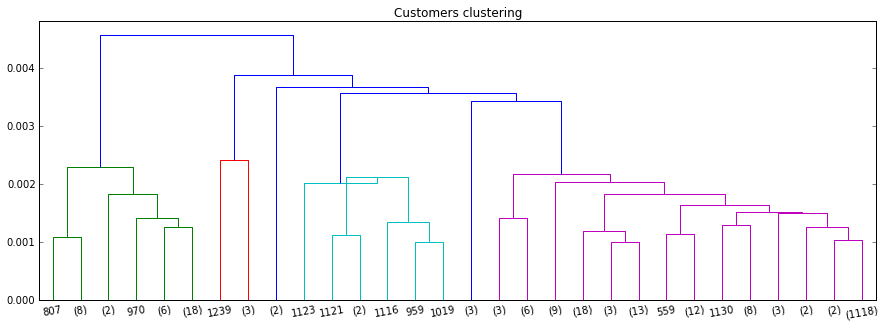

In [69]:
plt.figure(figsize=(15, 5))
Z = sch.dendrogram(L, truncate_mode='lastp')
plt.title("Customers clustering")
plt.show()

### With and without dimensionality reduction

In [70]:
tsne = TSNE(n_components=2, random_state=0)
T1 = tsne.fit_transform(td_train)

In [71]:
tsne = TSNE(n_components=2, random_state=0)
T2 = tsne.fit_transform(N)

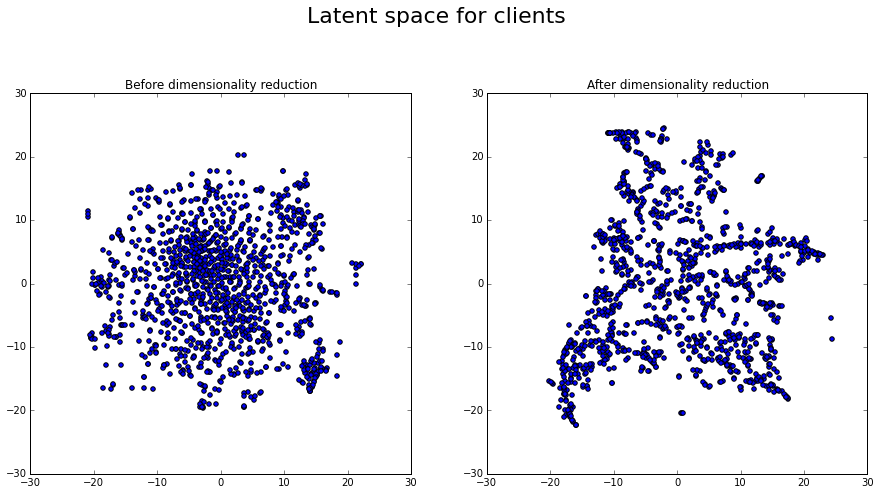

In [72]:
plt.figure(figsize=(15, 15))
plt.suptitle("Latent space for clients", size=22)
plt.subplot(2, 2, 1)
plt.scatter(T1[:, 0], T1[:, 1])
plt.title("Before dimensionality reduction")
plt.subplot(2, 2, 2)
plt.scatter(T2[:, 0], T2[:, 1])
plt.title("After dimensionality reduction")
plt.show()